In [2]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [3]:
device

device(type='mps')

In [4]:
from datasets import load_dataset

ds = load_dataset("ninadn/indian-legal")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.csv:   0%|          | 0.00/210M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/3.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7030 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

In [5]:
ds_train = ds['train'].select(range(2000))

In [6]:
text_len = [len(x['Text'].split()) for x in ds_train]
summary_len = [len(x['Summary'].split()) for x in ds_train]

array([[<Axes: title={'center': 'Text Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

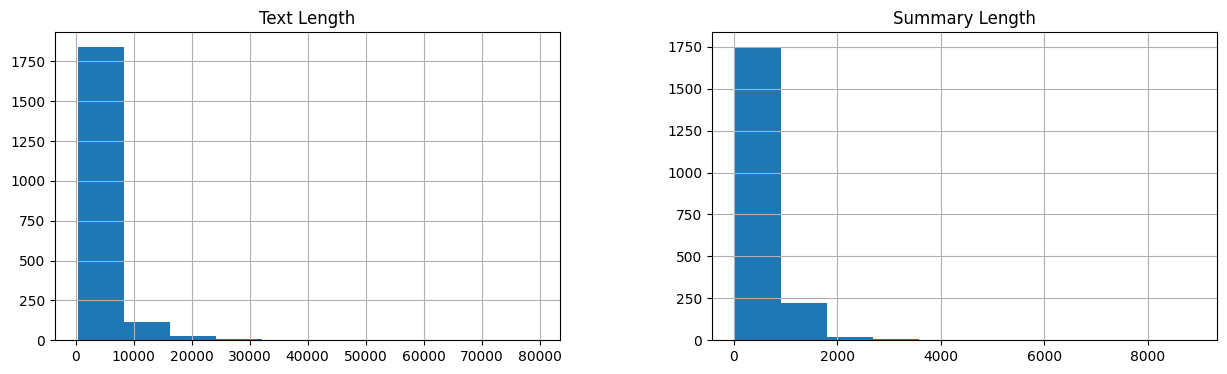

In [7]:
import pandas as pd

data = pd.DataFrame([text_len, summary_len]).T
data.columns = ['Text Length', 'Summary Length']

data.hist(figsize=(15,4))

In [8]:
from datasets import load_dataset
from transformers import pipeline

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [9]:
model_ckpt = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [10]:
def get_feature(batch):
  encodings = tokenizer(batch['Text'], text_target=batch['Summary'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

In [11]:
ds_pt = ds_train.map(get_feature, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [12]:
columns = ['input_ids', 'labels', 'attention_mask']
ds_pt.set_format(type='torch', columns=columns)

In [13]:
ds_pt

Dataset({
    features: ['Text', 'Summary', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2000
})

In [14]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [15]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'bart-leagl',
    num_train_epochs=1,
    warmup_steps = 500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16,
    remove_unused_columns=False
)

trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = ds_pt, eval_dataset = ds['test'])

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [4]:
model.train()

NameError: name 'model' is not defined